In [113]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg, scipy.integrate
import do2
from importlib import reload
from IPython.display import display, clear_output
from quantum_systems import ODQD, GeneralOrbitalSystem

In [114]:
### PARAMETERS ###
l = 10 # Number of eigenstates of the HO potential --> we use these functions to generate the single particle WF
grid_length = 10  # The width of the one-dimensional grid
num_grid_points = 201  # The number of discretized points on the grid.
# More points give better results for the single-particle basis at the cost of slower setup.
alpha = 1  # The strength of the Coulomb interaction 
a = 0.25  # The shielding parameter in the Coulomb interaction potential
Omega = 0.25  # The frequency of the harmonic oscillator trap
omega = 8*Omega # frequency of the laser field
epsilon0 = 1.0 # amplitude of the laser field
potential=ODQD.HOPotential(Omega)
nparticles = 2

In [183]:
reload(do2)
ghf = do2.GHF()
epsilon, C0, energy_ghf = ghf.solve_TIHF(tolerance=1e-12, max_iter=100, energy_per_step_ON=True)
time, overlap, dipole = ghf.solve_TDHF(dt=1e-3, t_max= 8*2*np.pi/omega, C0=C0, eval_overlap=True, eval_dipole=True)

C:\Users\Utente\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


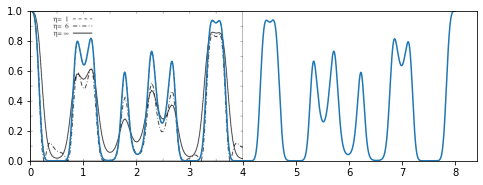

In [174]:
reload(do2)
ghf.plot_overlap(time, overlap)

C:\Users\Utente\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


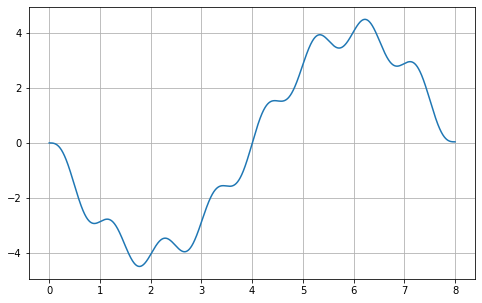

In [180]:
reload(do2)
ghf.plot_dipole(time, dipole)

In [187]:
reload(do2)
rhf = do2.RHF()
epsilon, C0, energy_rhf = rhf.solve_TIHF(tolerance=1e-15, max_iter=100, print_ON=True, energy_per_step_ON=True)
time, overlap, dipole = rhf.solve_TDHF(dt=1e-3, t_max= 8*2*np.pi/omega, C0=C0, eval_overlap=True, eval_dipole=True)

Max iteration number reached


C:\Users\Utente\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


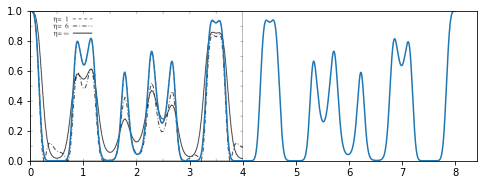

In [177]:
rhf.plot_overlap(time, overlap)

C:\Users\Utente\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


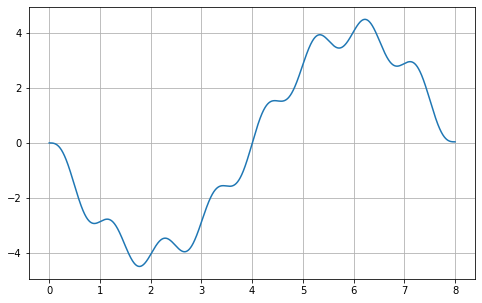

In [178]:
rhf.plot_dipole(time, dipole)

C:\Users\Utente\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Utente\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


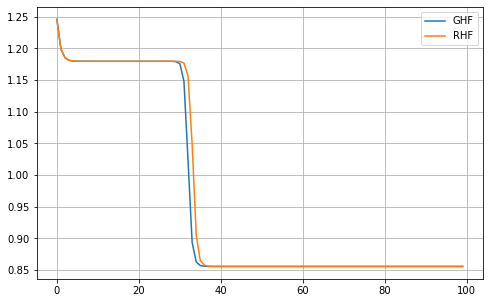

In [188]:
reload(do2)
ghf.plot_energy_per_iteration(energy_ghf, energy_rhf)

In [ ]:
# Matteo's version of the plotting
reload(do)
dt=1e-2
import matplotlib.animation as animation
fig, ax = plt.subplots()
x = np.linspace(0, 2*np.pi, 1000)
line, = ax.plot(system.grid, do.eval_one_body_density(system, nparticles, C0).real)
integrator = scipy.integrate.ode(rhs.f).set_integrator('zvode')
integrator.set_initial_value( np.reshape(C0, len(C0)**2 ), 0)
ani = animation.FuncAnimation(fig, do.animation, fargs=(line, system, dt, t_max, C0, omega, epsilon0, nparticles, integrator), interval=200, blit=True, save_count=1000)
from IPython.display import HTML
HTML(ani.to_jshtml())